# Recognize emotions on video with Python interface of EmotiEffLib

The first GPU device should be used for cuda

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


Function to download test data downloader:

In [30]:
import os
import urllib.request

def get_test_data_downloader(test_dir):
    input_file = os.path.join(test_dir, "download_test_data.sh")
    if os.path.isfile(input_file):
        return input_file
    url = "https://github.com/sb-ai-lab/EmotiEffLib/blob/main/tests/download_test_data.sh?raw=true"
    print("Downloading download_test_data.sh from", url)
    input_file = "download_test_data.sh"
    if os.path.isfile(input_file):
        return input_file
    urllib.request.urlretrieve(url, input_file)
    return input_file

Check if it runs under colab and install dependencies:

Prepare test data:

In [4]:
data_downloader = get_test_data_downloader("../../../tests")
!rm -rf data data.tar.gz
!sh {data_downloader}
!tar -xzf data.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=18aPD9S3FxGPzw_iF5SB1qvtq4iE3awEP
From (redirected): https://drive.google.com/uc?id=18aPD9S3FxGPzw_iF5SB1qvtq4iE3awEP&confirm=t&uuid=08752db3-66b1-4881-8073-68890b9f28c5
To: /Users/echuraev/Workspace/HSE/face-emotion-recognition/docs/tutorials/python/data.tar.gz
100%|██████████████████████████████████████| 84.7M/84.7M [00:29<00:00, 2.83MB/s]


Function for faces recognition:

In [31]:
from typing import List
import numpy as np

def recognize_faces(frame: np.ndarray, device: str) -> List[np.array]:
    """
    Detects faces in the given image and returns the facial images cropped from the original.

    This function reads an image from the specified path, detects faces using the MTCNN
    face detection model, and returns a list of cropped face images.

    Args:
        frame (numpy.ndarray): The image frame in which faces need to be detected.
        device (str): The device to run the MTCNN face detection model on, e.g., 'cpu' or 'cuda'.

    Returns:
        list: A list of numpy arrays, representing a cropped face image from the original image.

    Example:
        faces = recognize_faces('image.jpg', 'cuda')
        # faces contains the cropped face images detected in 'image.jpg'.
    """

    def detect_face(frame: np.ndarray):
        mtcnn = MTCNN(keep_all=False, post_process=False, min_face_size=40, device=device)
        bounding_boxes, probs = mtcnn.detect(frame, landmarks=False)
        if probs[0] is None:
            return []
        bounding_boxes = bounding_boxes[probs > 0.9]
        return bounding_boxes

    bounding_boxes = detect_face(frame)
    facial_images = []
    for bbox in bounding_boxes:
        box = bbox.astype(int)
        x1, y1, x2, y2 = box[0:4]
        facial_images.append(frame[y1:y2, x1:x2, :])
    return facial_images

## EmotiEffLib with ONNX

Install EmotiEffLib with ONNX support:

In [6]:
!pip install emotiefflib

Import libraries:

In [32]:
import os
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch import MTCNN
from emotiefflib.facial_analysis import EmotiEffLibRecognizer, get_model_list

Path to the directory with test data, select device and model:

In [6]:
test_dir = "data"
device = "cpu"
model_name = get_model_list()[0]

### Read video frame by frame and recognize emotions:

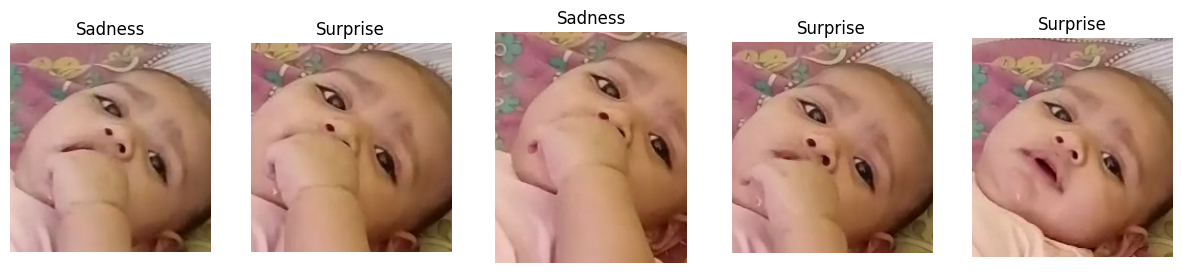

In [42]:
input_file =  "maysha.mp4"
fer = EmotiEffLibRecognizer(engine="onnx", model_name=model_name, device=device)

all_frames = []
all_scores = None
# Create a row of 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
i = 0

cap = cv2.VideoCapture(input_file)
while cap.isOpened():
    success, image = cap.read()
    if not success:
        break

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    facial_images = recognize_faces(image_rgb, device)
    facial_images = [img for img in facial_images if img is not None and img.size > 0]




    if len(facial_images) == 0:
        continue
    all_frames += facial_images
    # emotions, scores = fer.predict_emotions(facial_images, logits=True)
    if facial_images:
        emotions, scores = fer.predict_emotions(facial_images, logits=True)
    # Draw each 10th frame
    if i % 10 == 0 and i // 10 < 5:
        idx = i // 10
        axes[idx].imshow(facial_images[0])
        axes[idx].set_title(emotions[0])
        axes[idx].axis('off')
    i += 1
    if all_scores is not None:
        all_scores = np.concatenate((all_scores, scores))
    else:
        all_scores = scores

cap.release()

score = np.mean(all_scores, axis=0)
emotion_idx = np.argmax(score)

# assert fer.idx_to_emotion_class[emotion_idx] == "Anger"